### Automated Assessment of Car Damage Photos using SAS 

### Import the required packages including swat for accessing CAS actions
https://github.com/sassoftware/python-swat

In [11]:
# import the required packages 
from swat import *
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import cv2

# define the function to display the processed image files.
def imageShow(session, casTable, imageId, nimages):
    a = session.table.fetch(sastypes=False,sortby=[{'name':'_id_'}],table=casTable,to=nimages)
    fig = plt.figure(figsize=(20, 20))
    for i in range(nimages):
        imageData = a['Fetch'].ix[ i][ imageId]
        img_np = cv2.imdecode(np.fromstring( imageData, np.uint8),1)
        fig.add_subplot(1,nimages,i+1)
        plt.imshow(img_np)
        img_np[:,:,[0,2]]=img_np[:,:,[2,0]]
        plt.xticks([]), plt.yticks([])

### Set up the environment and Connect to SAS from Python
#### Creating an Authinfo file: 
http://go.documentation.sas.com/?docsetId=caspg&docsetTarget=n0i9fvsmff624fn1nh29sa6cx6lk.htm&docsetVersion=3.2&locale=en


In [9]:
# define the host machine and port for CAS connection: port is 5570 from Linux client and 8777 from Windows client.
hostmachine = 'my-viya-server.my-domain.com'
port = 8777
# authentication file on the client machine with user name and password (see the link above).
_authinfo = r"my-local-path\_authinfo"
# path on the Viya server where the image files to be processed are stored.
path_source_images    = "my-host-path-for-sources"
path_reference_images = "my-host-path-for-references"

# set up a CAS session.
conn = CAS(hostmachine, port, authinfo = _authinfo)
# load CAS image action set for processing images.
conn.loadactionset('image')

NOTE: Added action set 'image'.


[actionset]

 'image'

+ Elapsed: 0.00986s, user: 0.008s, sys: 0.01s, mem: 0.141mb

### Load images and resize

NOTE: Loaded 4 images from /viyafiles/turtui/image_processing/car_accident into Cloud Analytic Services table inputTable.
NOTE: Table INPUTTABLE contains compressed images.
NOTE: 4 out of 4 images were processed successfully and saved as compressed images to the Cloud Analytic Services table inputTable_resized.


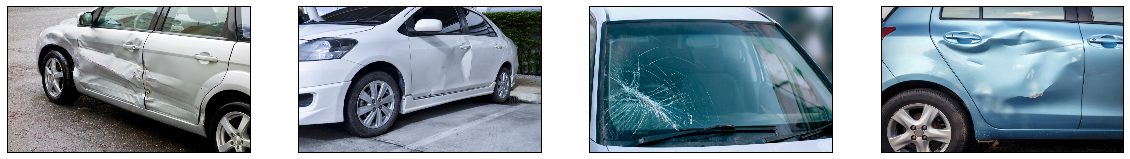

In [4]:
conn.image.loadImages(casout={'name':'inputTable', 'replace':True}, path= path_source_images)
conn.image.processimages(casout={'name':'inputTable_resized', 'replace':True},
                       imagefunctions=[{'functionoptions':{'width':1000,'functiontype':'RESIZE','height':600}}],
                       imagetable={'name':'inputTable'})
imageTable = conn.CASTable('inputTable_resized')
imageShow(conn, imageTable, 0, 4)

### Convert colours

In [5]:
r = conn.image.processImages(casout={'name':'resultingImages','replace':True},
        imagetable={'name':'inputTable_resized'},
        imagefunctions=[
            {'options':{'functiontype':'CONVERT_COLOR'}} #change color space
    ])
print(r)
outTable = conn.CASTable('resultingImages')
type(outTable)

NOTE: Table INPUTTABLE_RESIZED contains compressed images.
NOTE: 4 out of 4 images were processed successfully and saved as compressed images to the Cloud Analytic Services table resultingImages.
+ Elapsed: 0.0659s, user: 0.147s, sys: 0.058s, mem: 198mb


swat.cas.table.CASTable

NOTE: Table INPUTTABLE_RESIZED contains compressed images.
NOTE: 4 out of 4 images were processed successfully and saved as compressed images to the Cloud Analytic Services table resultingImages.
+ Elapsed: 0.13s, user: 0.157s, sys: 0.058s, mem: 196mb


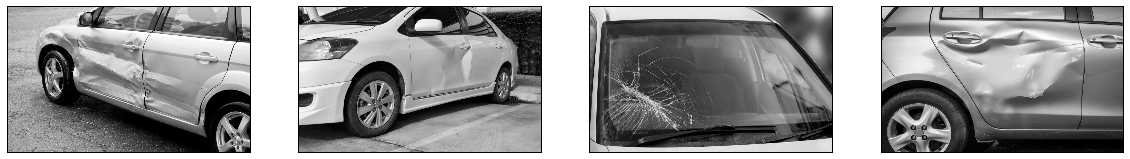

In [6]:
imageShow(conn, outTable, 0, 4)

### Apply noise reduction and binarization

NOTE: Table INPUTTABLE_RESIZED contains compressed images.
NOTE: 4 out of 4 images were processed successfully and saved as compressed images to the Cloud Analytic Services table resultingImages.
+ Elapsed: 0.559s, user: 1.69s, sys: 0.045s, mem: 195mb


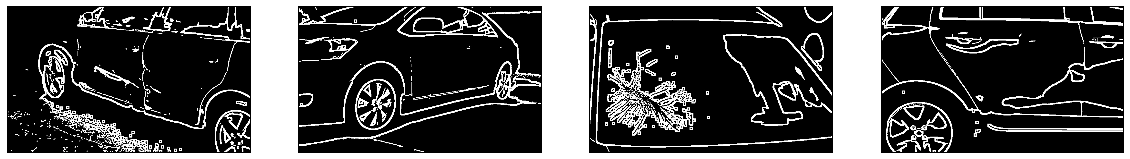

In [8]:
r = conn.image.processImages(casout={'name':'resultingImages','replace':True},
        imagetable={'name':'inputTable_resized'},
        imagefunctions=[
            {'options':{'functiontype':'CONVERT_COLOR'}}, #change color space
        
            {'options':{'functiontype':'BILATERAL_FILTER', #noise reduction
                        'diameter':13,'sigmacolor':30,'sigmaspace':30}},
        
            {'options':{'functiontype':'THRESHOLD', #image binarization
                        'type':'OTSU','value':125}},
            {'options':{'functiontype':'LAPLACIAN', #edge detection with the Laplace operator
                        'kernelsize':12}}
           
    ])
print(r)
outTable = conn.CASTable('resultingImages')
imageShow(conn, outTable, 0, 4)

In [7]:
outTable.head(4)

,_image_,_size_,_path_,_type_,_id_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,167660,/viyafiles/turtui/image_processing/car_acciden...,jpg,1
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,118477,/viyafiles/turtui/image_processing/car_acciden...,jpg,4
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,136005,/viyafiles/turtui/image_processing/car_acciden...,jpg,2
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,152709,/viyafiles/turtui/image_processing/car_acciden...,jpg,3


### Compare images with the labeled images in the historical data 
Using the similarity index for decision making

In [ ]:
# Process reference files to compare.
conn.image.loadImages(casout={'name':'inTable', 'replace':True}, path= 'path_reference_images')
conn.image.processImages(casout={'name':'refTable','replace':True},
        imagetable={'name':'inTable'},
        imagefunctions=[{'functionoptions':{'width':1000,'functiontype':'RESIZE','height':600}}, # resize
            {'options':{'functiontype':'CONVERT_COLOR'}}, #change color space
        
            {'options':{'functiontype':'BILATERAL_FILTER', #noise reduction
                        'diameter':13,'sigmacolor':30,'sigmaspace':30}},
            {'options':{'functiontype':'THRESHOLD', #image binarization
                        'type':'OTSU','value':125}}
           
    ])

In [16]:
# Compare reference and source images to find the similarity index.
results = conn.image.compareImages(
        casOut={
            "name":"output",
            "replace":True
        },
        pairAll=True,
        referenceImages={
            "table":{
            "name":'refTable'
        }},
        sourceImages={
            "table":{
            "name":'resultingImages'
        }}
    )

scoreTable = conn.CASTable("output")
del scoreTable['_channel4_'] 
del scoreTable['_channel3_']
print(results)
print(scoreTable.head())

+ Elapsed: 0.184s, user: 0.36s, sys: 0.293s, mem: 196mb
Selected Rows from Table OUTPUT

   _channel1_  _channel2_          _source_id_      _reference_id_
0    0.293083         1.0  image_171148832.jpg  high_191268710.jpg
1    0.416457         1.0  image_171148832.jpg    med_73907023.jpg
2    0.339034         1.0  image_171148832.jpg   high_84474664.jpg
3    0.389290         1.0  image_190287860.jpg  high_191268710.jpg
4    0.391424         1.0  image_190287860.jpg    med_73907023.jpg


In [ ]:
# end the CAS session.
conn.session.endsession()

### NEXT STEPS: 
Building a convolutional neural network model on the historical dataset to extract the features from images and finding the likelihood probabilities of small/medium/high damages or estimating the cost of the damage. 